The following piece of code downloads and updates all the important liberaries used to latest versions.

In [1]:
%pip install --upgrade pip
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install gymnasium[classic_control]
%pip install torch 


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

Following imports all the liberary and redefines them for convinience

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import math

Assignment-01

Task 1: Tabular Q-Learning Update

In [3]:
def init_q_table(n_states, n_actions):

    table = np.zeros((n_states, n_actions))
    return table


def q_update(q_table, state, action, reward, state_next, alpha, gamma):
    q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[state_next]) - q_table[state, action])
    return q_table



Task 2: ε-Greedy Policy on a Custom GridWorld

In [4]:
def rl_agent_training(number_of_episodes, initial_epsilon, final_epsilon, alpha, gamma, max_steps):
    q_table = init_q_table(16, 4)

    grid = np.array([[-1, -1, -1, -1],
                     [-1, -1, -1, -1],
                     [-1, -10, -1, -1],
                     [-1, -1, -1, 10]])

    rewards_per_episode = []
    actual_epsilon = initial_epsilon
    epsilon_decay = (initial_epsilon - final_epsilon) / number_of_episodes if number_of_episodes > 0 else 0

    for i in range(number_of_episodes):
        location_y = 0
        location_x = 0
        location = location_y * 4 + location_x
        step_count = 0
        episode_reward = 0

        while(location != 15 and step_count < max_steps):
            step_count += 1
            chance = random.random()
            valid_action = False
            if chance < actual_epsilon:
                while(not valid_action):
                    action = random.randint(0, 3)
                    if action == 0 and location_x > 0:  # 0 represents left
                        valid_action = True
                        location_x = location_x - 1
                    elif action == 1 and location_x < 3:  # 1 represents right
                        valid_action = True
                        location_x = location_x + 1
                    elif action == 2 and location_y > 0:  # 2 represents up
                        valid_action = True
                        location_y = location_y - 1
                    elif action == 3 and location_y < 3:  # 3 represents down
                        valid_action = True
                        location_y = location_y + 1
                new_location = location_y * 4 + location_x
                reward = grid[location_x][location_y]
                episode_reward += reward
                q_table = q_update(q_table, location, action, grid[location_x][location_y], new_location, alpha, gamma)
                location = new_location
            else:
                proper_action = []
                for action in range(4):
                    if action == 0 and location_x > 0:
                        proper_action.append(action)
                    elif action == 1 and location_x < 3:
                        proper_action.append(action)
                    elif action == 2 and location_y > 0:
                        proper_action.append(action)
                    elif action == 3 and location_y < 3:
                        proper_action.append(action)

                action = proper_action[np.argmax(q_table[location, proper_action])]
                if action == 0:
                    location_x = location_x - 1
                elif action == 1:
                    location_x = location_x + 1
                elif action == 2:
                    location_y = location_y - 1
                elif action == 3:
                    location_y = location_y + 1
                new_location = location_y * 4 + location_x

                reward = grid[location_x][location_y]
                episode_reward += reward
                q_table = q_update(q_table, location, action, grid[location_x][location_y], new_location, alpha, gamma)
                location = new_location

        if location == 15:
            reward = 0
            episode_reward += reward

        actual_epsilon = max(final_epsilon, actual_epsilon - epsilon_decay)
        rewards_per_episode.append(episode_reward)

    return rewards_per_episode
            


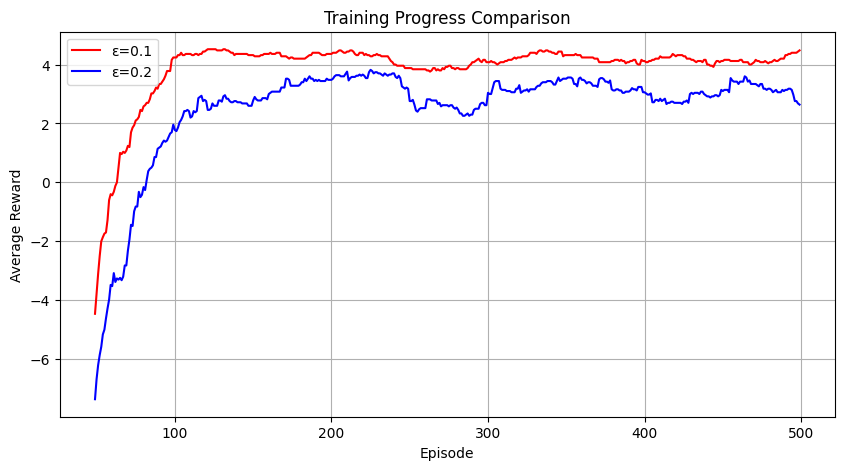

In [5]:
def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size).mean()

# Run two different training configurations
rewards1 = rl_agent_training(500, 0.1, 0.1, 0.1, 0.99, 20)
rewards2 = rl_agent_training(500, 0.2, 0.2, 0.1, 0.99, 20)

# Calculate moving averages
window_size = 50
moving_avg1 = moving_average(rewards1, window_size)
moving_avg2 = moving_average(rewards2, window_size)

# Plot both moving averages on same graph
plt.figure(figsize=(10, 5))
plt.plot(moving_avg1, color='red', label='ε=0.1')
plt.plot(moving_avg2, color='blue', label='ε=0.2')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Training Progress Comparison')
plt.legend()
plt.grid(True)
plt.show()

The conclusions that we can draw from above graph is that when the probability of random action (epsilon) is 0.1 the moving average is higher than when it is 0.2 as in both cases it has reached a optimal q table but when epsilon is 0.2 it more often performs a random action leading to a lower reward

Also, when epsilon is 0.1, the agents learns faster as it is exploiting a good stratergy more that focusing on exploring as compared to when epsilon is 0.2

Task 3: Experience Replay Buffer

Creating a Replay Buffer to store recent previous states to chose random states reducing the temporal interference and increasing the stability of the neural network or Q-function learned by our agent

In [6]:
class ReplayBuffer:
    
    def __init__ (self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=buffer_size)
        

    def push (self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        if batch_size > len(self.buffer):
            return None, None, None, None, None
        batch = random.sample(list(self.buffer), batch_size)

        sample_state = batch[0][0]
        state_shape = np.shape(sample_state)
        
        if isinstance(sample_state, (list, np.ndarray)) and len(state_shape) > 0:
            # For vector states (like CartPole)
            states = np.zeros((batch_size, *state_shape), dtype=np.float32)
            next_states = np.zeros((batch_size, *state_shape), dtype=np.float32)
        else:
            # For scalar states (like your simple grid world)
            states = np.empty(batch_size, dtype=np.int32)
            next_states = np.empty(batch_size, dtype=np.int32)
            
        actions = np.empty(batch_size, dtype=np.int32)
        rewards = np.empty(batch_size, dtype=np.float32)
        dones = np.empty(batch_size, dtype=np.bool_)

        for i in range(batch_size):
            states[i] = batch[i][0]
            actions[i] = batch[i][1]
            rewards[i] = batch[i][2]
            next_states[i] = batch[i][3]
            dones[i] = batch[i][4]

        return states, actions, rewards, next_states, dones
        
recent_buffer = ReplayBuffer(100)

for i in range(100):
    state = random.randint(0, 15)
    action = random.randint(0, 3)
    reward = random.uniform(-10,10)
    next_state = random.randint(0, 15)
    done = random.choice([True, False])
    recent_buffer.push(state, action, reward, next_state, done)

states, actions, rewards, next_states, dones = recent_buffer.sample(32)

print ("States type and shape - : ",states.dtype, states.shape)
print ("Actions type and shape - : ",actions.dtype, actions.shape)
print ("Rewards type and shape - : ",rewards.dtype, rewards.shape)
print ("Next states type and shape - : ",next_states.dtype, next_states.shape)
print ("Dones type and shape - : ",dones.dtype, dones.shape)


States type and shape - :  int32 (32,)
Actions type and shape - :  int32 (32,)
Rewards type and shape - :  float32 (32,)
Next states type and shape - :  int32 (32,)
Dones type and shape - :  bool (32,)


Task 4: Deep Q-Network with Target Copy

This declares the 2 identical neural networks used to form our RL agent, with 3 layers connected using ReLu and an Update function to copy the wights of connections from policy to target

In [7]:
class DQNPolicy(nn.Module):
    def __init__(self, input_dimention, output_dimention):
        super(DQNPolicy, self).__init__()
        self.fc1 = nn.Linear(input_dimention, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dimention)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    
class DQNTarget(nn.Module):
    def __init__(self, input_dimention, output_dimention):
        super(DQNTarget, self).__init__()
        self.fc1 = nn.Linear(input_dimention, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dimention)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    
def update_target_network(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    return target_net

Task 5: Full DQN Training Loop on CartPole-v1

Forming the environment, declaring agent and all the Hyper-parameters to tune the training process

In [8]:
env=gym.make("CartPole-v1") 

Batch_size = 32
buffer_size = 10000
initial_epsilon = 1.0
final_epsilon = 0.1
decay = 500
epsilon_decay = (initial_epsilon - final_epsilon) / decay
alpha = 0.0001
gamma = 0.99
n_episodes = 1000

action_space = env.action_space.n
state,info = env.reset()

state_dim = len(state)

policy_net = DQNPolicy(state_dim, action_space)
target_net = DQNTarget(state_dim, action_space)

optimzer = optim.Adam(policy_net.parameters(), lr=alpha, amsgrad=True)
loss_fn = nn.MSELoss()
Buffer=ReplayBuffer(buffer_size)



This code implements ε-greedy action selection, runs for n_episodes, resetting the environment each time and trains the model from random states. After a fixed no. of episodes, copies the trained policy model into target model and repeates the training process.
ε decays linearly from initial_epsilon down to final_epsilon to reduce exploration over time.Tracks episode rewards and counts “successes” (reward ≥ 195).

After training, computes a moving average of rewards and plots it to visualize learning progress. 


Episode 0/1000, Reward: 27.0, Epsilon: 1.00
Episode 50/1000, Reward: 10.0, Epsilon: 0.91
Episode 100/1000, Reward: 69.0, Epsilon: 0.82
Episode 150/1000, Reward: 36.0, Epsilon: 0.73
Episode 200/1000, Reward: 33.0, Epsilon: 0.64
Episode 250/1000, Reward: 47.0, Epsilon: 0.55
Episode 300/1000, Reward: 104.0, Epsilon: 0.46
Episode 350/1000, Reward: 234.0, Epsilon: 0.37
Episode 400/1000, Reward: 306.0, Epsilon: 0.28
Episode 450/1000, Reward: 205.0, Epsilon: 0.19
Episode 500/1000, Reward: 189.0, Epsilon: 0.10
Episode 550/1000, Reward: 178.0, Epsilon: 0.10
Episode 600/1000, Reward: 193.0, Epsilon: 0.10
Episode 650/1000, Reward: 205.0, Epsilon: 0.10
Episode 700/1000, Reward: 234.0, Epsilon: 0.10
Episode 750/1000, Reward: 237.0, Epsilon: 0.10
Episode 800/1000, Reward: 219.0, Epsilon: 0.10
Episode 850/1000, Reward: 415.0, Epsilon: 0.10
Episode 900/1000, Reward: 236.0, Epsilon: 0.10
Episode 950/1000, Reward: 238.0, Epsilon: 0.10
Success rate: 52.40%


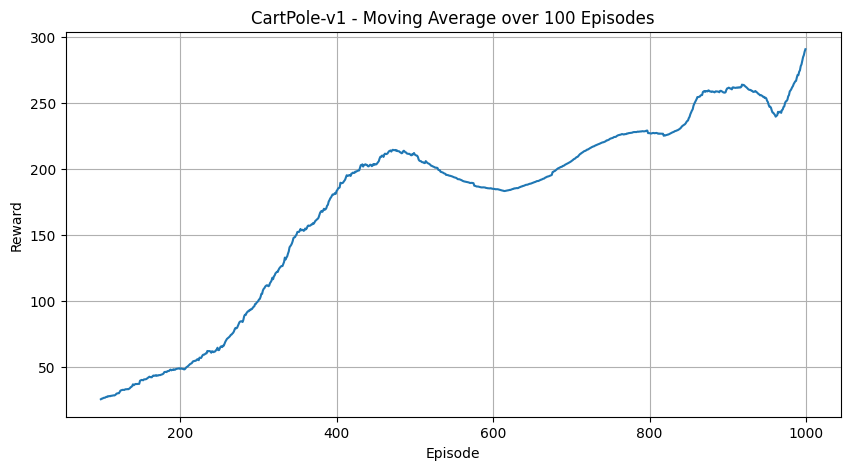

In [9]:
def select_action(state, policy_net, epsilon, device="cpu"):

    if random.random() < epsilon:
        return random.randint(0, action_space-1)
    else:
        with torch.no_grad():

            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state)
            return q_values.max(1)[1].item()

def train_dqn(n_episodes, target_update_freq, plot_interval):
    global Buffer, policy_net, target_net, optimzer, loss_fn, action_space, initial_epsilon, final_epsilon, epsilon_decay, gamma

    rewards = []
    epsilon = initial_epsilon
    target_update_freq = target_update_freq
    success_count = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            action = select_action(state, policy_net, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            
            Buffer.push(state, action, reward, next_state, done or truncated)
            state = next_state
            
            if len(Buffer.buffer) >= Batch_size:
                samples = Buffer.sample(Batch_size)
                if samples is not None:
                    states, actions, rewards_batch, next_states, dones = samples
                    
                    states = np.array([np.array(s, dtype=np.float32) for s in states])
                    next_states = np.array([np.array(s, dtype=np.float32) for s in next_states])
                    
                    states = torch.FloatTensor(states)
                    next_states = torch.FloatTensor(next_states)
                    actions = torch.LongTensor(actions)
                    rewards_batch = torch.FloatTensor(rewards_batch)
                    dones = torch.BoolTensor(dones)
                
                    current_q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                    with torch.no_grad():
                        next_q_values = target_net(next_states).max(1)[0]
                        next_q_values[dones] = 0.0
                        target_q_values = rewards_batch + gamma * next_q_values
                
                    loss = loss_fn(current_q_values, target_q_values)
                
                    optimzer.zero_grad()
                    loss.backward()
                    optimzer.step()
        
        if episode % target_update_freq == 0:
            target_net = update_target_network(policy_net, target_net)
        epsilon = max(final_epsilon, epsilon - epsilon_decay)
        rewards.append(episode_reward)
        
        if episode_reward >= 195:
            success_count += 1
            
        if episode % (n_episodes / 20) == 0:
            print(f"Episode {episode}/{n_episodes}, Reward: {episode_reward:.1f}, Epsilon: {epsilon:.2f}")
    
    success_rate = (success_count / n_episodes) * 100
    print(f"Success rate: {success_rate:.2f}%")
    
    return rewards

all_rewards = train_dqn(n_episodes, target_update_freq=10, plot_interval=50)


window_size = max(1, n_episodes // 10)  
moving_rewards = moving_average(all_rewards, window_size)

plt.figure(figsize=(10, 5))
plt.plot(moving_rewards)
plt.title(f'CartPole-v1 - Moving Average over {window_size} Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()